In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
!pip install fastbook
import fastbook
fastbook.setup_book()

In [24]:
from fastbook import *
from fastai.vision.widgets import *


In [25]:
key = os.environ.get("AZURE_SEARCH_KEY", "3bed4a7ce8ff431bb03e7478f5bb0cc7")

In [26]:
results = search_images_bing(key, "Carl Sagan")
images = results.attrgot('contentUrl')
len(images)

150

In [27]:
dest = "images/Carl.jpg"
download_url(images[0], dest)

Path('images/Carl.jpg')

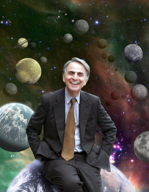

In [28]:
image = Image.open(dest)
image.to_thumb(192,192)

In [29]:
types = ["c", "r"]
path = Path("guys")

In [30]:
if not path.exists():
    path.mkdir()
    for o in types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, "Carl Sagan" if o == "c" else "Richard Feynman")
        download_images(dest, urls=results.attrgot('contentUrl'))

In [31]:
file_names = get_image_files(path)
file_names

(#274) [Path('guys/richard/73ba3a51-2137-473e-9fa9-2556f796340b.jpg'),Path('guys/richard/f0670d91-802d-4505-af11-973b25c27b43.jpg'),Path('guys/richard/deba51b8-4879-4ccb-a40e-9a79d4c98e18.jpg'),Path('guys/richard/3cca478a-9109-40ae-91e3-dfa852e9b33b.png'),Path('guys/richard/491c245e-0274-499d-91ae-6450af02bcab.jpg'),Path('guys/richard/53d55d51-4a62-45c1-a069-fac9323f2b6a.jpg'),Path('guys/richard/bb14f559-0b10-4cd1-b47b-967db277dcaa.jpg'),Path('guys/richard/af9003ab-d9e3-404a-bad7-aca562284578.jpg'),Path('guys/richard/8663fb99-cb25-476f-ab6c-2e93f6adf86b.jpg'),Path('guys/richard/2d684d14-86b6-4c1b-b298-af6d3c77a450.jpg')...]

In [32]:
failed = verify_images(file_names)
failed

(#0) []

In [33]:
failed.map(Path.unlink)

(#0) []

In [34]:
guys = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)
)

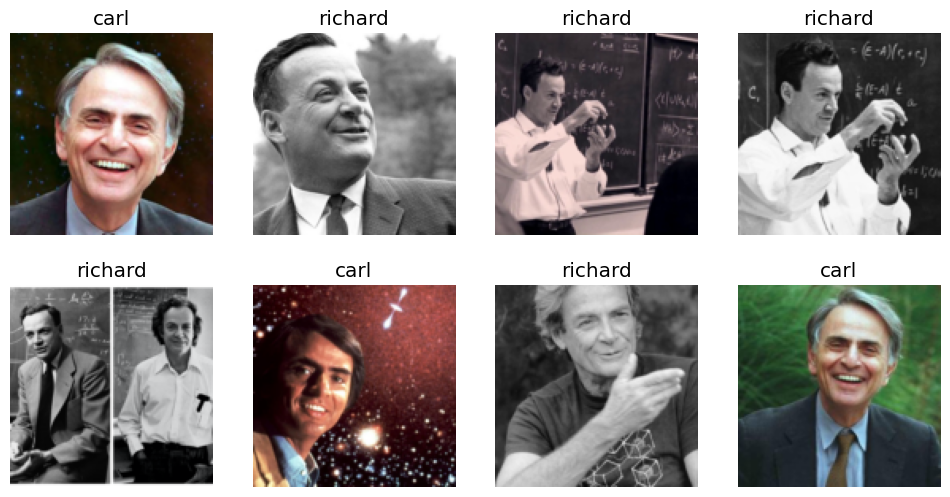

In [35]:
dls = guys.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

In [36]:
guys = guys.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                batch_tfms=aug_transforms())
dls = guys.dataloaders(path)

In [37]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 92.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.352345,0.781711,0.351852,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.644349,0.509215,0.185185,00:07
1,0.587450,0.347438,0.129630,00:06
2,0.462511,0.191164,0.074074,00:06
3,0.360883,0.120504,0.018519,00:07


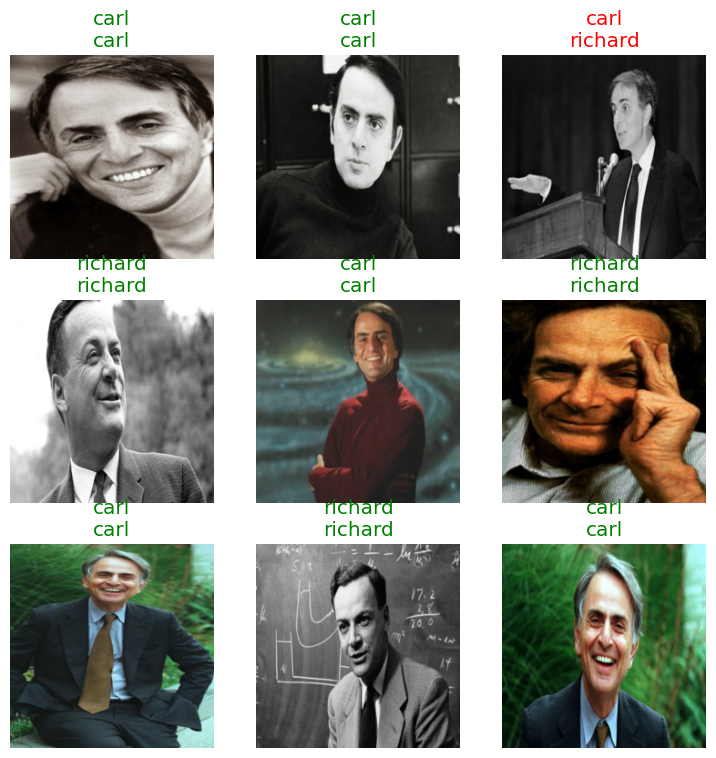

In [38]:
learn.show_results()

In [39]:
#!pip install ipywidgets
from fastai.vision.all import *
import ipywidgets as widgets
upload = widgets.FileUpload()
upload

FileUpload(value={}, description='Upload')

In [40]:
image = PILImage.create(upload.data[0])
is_carl, _, prob = learn.predict(image)
print(f"Does this image contain Carl Sagan? {'Yes' if is_carl else 'No'}.")
print(f"Probability that it's Carl Sagan: {prob[0].item():.6f}")

IndexError: list index out of range

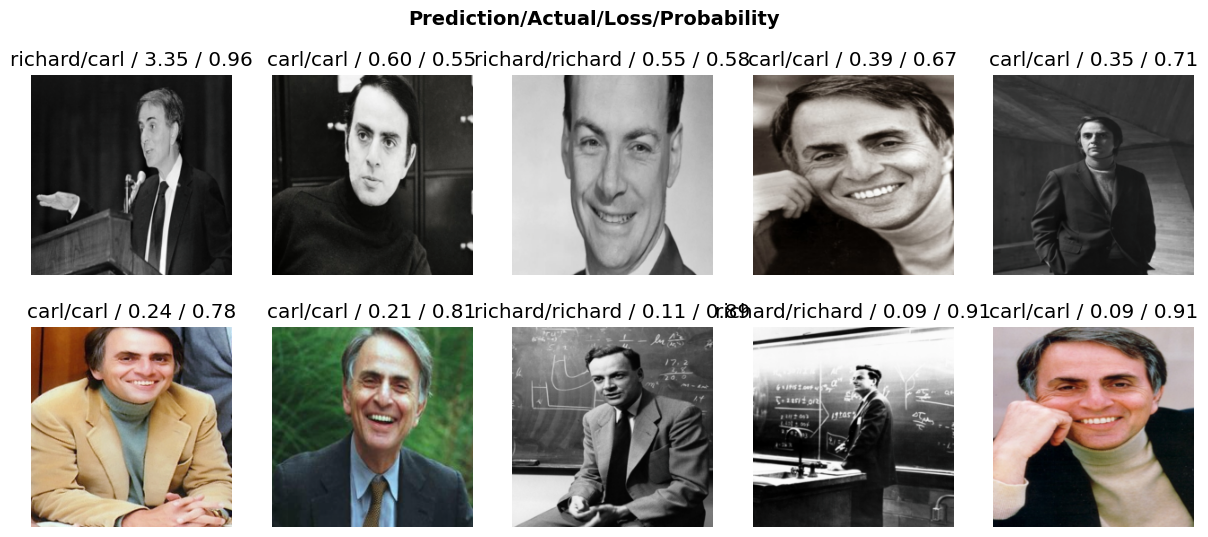

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(10, nrows=2)

## Making the app

In [43]:
learn.export()
path = Path()
path.ls(file_exts=".pkl")

(#1) [Path('export.pkl')]

In [47]:
import ipywidgets as widgets
learn_inf = load_learner(path/'export.pkl')
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [49]:
img = PILImage.create(uploader.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [51]:
pred,pred_idx,probs = learn_inf.predict(img)
label = widgets.Label()
label.value = f"Prediction: {pred.capitalize()}. Probability: {probs[pred_idx]:.04f}"
label

Label(value='Prediction: Carl. Probability: 0.9745')

In [52]:
run_button = widgets.Button(description="Classify")
run_button

Button(description='Classify', style=ButtonStyle())

In [53]:
def on_click_classify(change):
    img = PILImage.create(uploader.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    label.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

run_button.on_click(on_click_classify)

In [56]:
VBox([widgets.Label('Upload a picture of Carl Sagan or Richard Feynman.'), 
      uploader, run_button, out_pl, label])

In [61]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.5/347.5 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter_client 7.4.9
    Uninstalling jupyter_client-7.4.9:
      Successfully uninstalled jupyter_client-7.4.9
  Attempting uninstall: jupyter-server
    Found existing installation: jupyter_server 2.5.0
    Uninstalling jupyter_server-2.5.0:
      Successfully uninstalled jupyter_server-2.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-lsp 4.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
Config option `kernel_spec_manager_class` not recognized by `EnableServerExtensionApp`.
Enabling: voil